# 02. Selection Signal Analysis

이 노트북은 레이어 선택 신호(PCL, ILM, Probe)와 최종 성능 간의 상관관계를 분석합니다.

## 목차
1. 환경 설정 및 데이터 로딩
2. Q2: Signal-Performance Correlation
3. PCL Score 시각화
4. ILM Head Effect 시각화
5. Probe Accuracy 분석
6. 신호 조합 효과

## 1. 환경 설정

In [1]:
import json
import os
import sys
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr

# 논문용 스타일 설정
plt.rcParams.update({
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 14,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
})
sns.set_style("whitegrid")

# 프로젝트 루트 설정
PROJECT_ROOT = Path("..")
RESULTS_DIR = PROJECT_ROOT / "results"
FIGURES_DIR = Path("figures")
FIGURES_DIR.mkdir(exist_ok=True)

# 색상 팔레트
COLORS = {
    "keyword": "#3498db",     # 파랑
    "corr": "#9b59b6",        # 보라
    "combined": "#2ecc71",    # 초록
    "ilm": "#e74c3c",         # 빨강
    "probe": "#f39c12",       # 주황
    "acc": "#34495e",         # 회색
}

print(f"Project root: {PROJECT_ROOT.resolve()}")

Project root: /home/yskim/project/PiFi


### 1.1 Selection 로그 로딩

In [2]:
def load_selection_log(path: Path) -> Optional[Dict]:
    """Selection 로그 JSON 파일을 로드합니다."""
    if not path.exists():
        return None
    try:
        return json.loads(path.read_text())
    except:
        return None


def find_all_selection_logs(results_dir: Path) -> List[Path]:
    """모든 selection 로그 파일을 찾습니다."""
    patterns = [
        "**/selection.json",
        "**/*_selection.json",
        "**/layer_selection/**/*.json",
    ]
    logs = []
    for pattern in patterns:
        logs.extend(results_dir.glob(pattern))
    return list(set(logs))


def extract_per_layer_signals(log: Dict) -> pd.DataFrame:
    """
    Selection 로그에서 레이어별 신호를 추출합니다.
    """
    if "per_layer_signals" not in log:
        return pd.DataFrame()
    
    rows = []
    for sig in log["per_layer_signals"]:
        rows.append({
            "layer": sig.get("layer", 0),
            "keyword_signal": sig.get("keyword_signal", 0.0),
            "corr_signal": sig.get("corr_signal", 0.0),
        })
    
    df = pd.DataFrame(rows)
    if not df.empty:
        # Combined score 계산 (기본 가중치 0.65)
        keyword_weight = log.get("keyword_weight", 0.65)
        df["combined_score"] = (keyword_weight * df["keyword_signal"] + 
                                 (1 - keyword_weight) * df["corr_signal"])
    
    return df


# 로그 찾기
log_paths = find_all_selection_logs(RESULTS_DIR)
print(f"Found {len(log_paths)} selection log files")

if not log_paths:
    print("No selection logs found. Creating synthetic data for demonstration.")

Found 0 selection log files
No selection logs found. Creating synthetic data for demonstration.


In [3]:
def create_synthetic_signal_data(n_layers: int = 28, seed: int = 42) -> Tuple[pd.DataFrame, Dict]:
    """
    실제 로그가 없을 때 시연용 합성 신호 데이터를 생성합니다.
    """
    np.random.seed(seed)
    
    layers = np.arange(n_layers)
    
    # Keyword signal: 중간-후반 레이어에서 피크
    keyword_peak = n_layers * 0.6
    keyword_signal = 0.3 + 0.5 * np.exp(-((layers - keyword_peak) ** 2) / (2 * (n_layers / 4) ** 2))
    keyword_signal += np.random.normal(0, 0.05, n_layers)
    keyword_signal = np.clip(keyword_signal, 0, 1)
    
    # Correlation signal: 초반-중반에서 피크
    corr_peak = n_layers * 0.4
    corr_signal = 0.2 + 0.4 * np.exp(-((layers - corr_peak) ** 2) / (2 * (n_layers / 5) ** 2))
    corr_signal += np.random.normal(0, 0.03, n_layers)
    corr_signal = np.clip(corr_signal, 0, 1)
    
    # Accuracy: keyword와 corr의 조합과 어느 정도 상관
    combined = 0.65 * keyword_signal + 0.35 * corr_signal
    acc = 0.80 + 0.08 * combined + np.random.normal(0, 0.01, n_layers)
    acc = np.clip(acc, 0.75, 0.95)
    
    df = pd.DataFrame({
        "layer": layers,
        "keyword_signal": keyword_signal,
        "corr_signal": corr_signal,
        "combined_score": combined,
        "acc": acc,
    })
    
    # 메타데이터
    meta = {
        "task": "classification",
        "dataset": "sst2",
        "llm_type": "qwen2_1.5b",
        "L_Abstract": int(np.argmax(combined)),
        "keywords": ["good", "bad", "movie", "great", "terrible", "love", "hate", "best"],
        "base_acc": float(acc.mean()),
    }
    
    return df, meta


# 합성 데이터 생성 (실제 로그가 없을 때)
if not log_paths:
    signal_df, signal_meta = create_synthetic_signal_data()
    print("Created synthetic signal data for demonstration")
    signal_df.head()

Created synthetic signal data for demonstration


## 2. Q2: Signal-Performance Correlation

In [4]:
def compute_signal_correlations(signal_df: pd.DataFrame) -> pd.DataFrame:
    """
    각 신호와 accuracy 간의 상관계수를 계산합니다.
    """
    if "acc" not in signal_df.columns:
        print("Warning: 'acc' column not found")
        return pd.DataFrame()
    
    signals = ["keyword_signal", "corr_signal", "combined_score"]
    results = []
    
    for sig in signals:
        if sig not in signal_df.columns:
            continue
        
        x = signal_df[sig].values
        y = signal_df["acc"].values
        
        # Pearson correlation
        pearson_r, pearson_p = pearsonr(x, y)
        
        # Spearman correlation
        spearman_r, spearman_p = spearmanr(x, y)
        
        results.append({
            "signal": sig,
            "pearson_r": pearson_r,
            "pearson_p": pearson_p,
            "spearman_rho": spearman_r,
            "spearman_p": spearman_p,
        })
    
    return pd.DataFrame(results)


# 상관계수 계산
if 'signal_df' in dir():
    corr_df = compute_signal_correlations(signal_df)
    print("=" * 60)
    print("Q2: Signal-Performance Correlation Analysis")
    print("=" * 60)
    display(corr_df)

Q2: Signal-Performance Correlation Analysis


,signal,pearson_r,pearson_p,spearman_rho,spearman_p
0,keyword_signal,0.659688,0.000134,0.638205,0.000258
1,corr_signal,0.564703,0.001744,0.600438,0.000730
2,combined_score,0.753122,0.000004,0.753147,0.000004


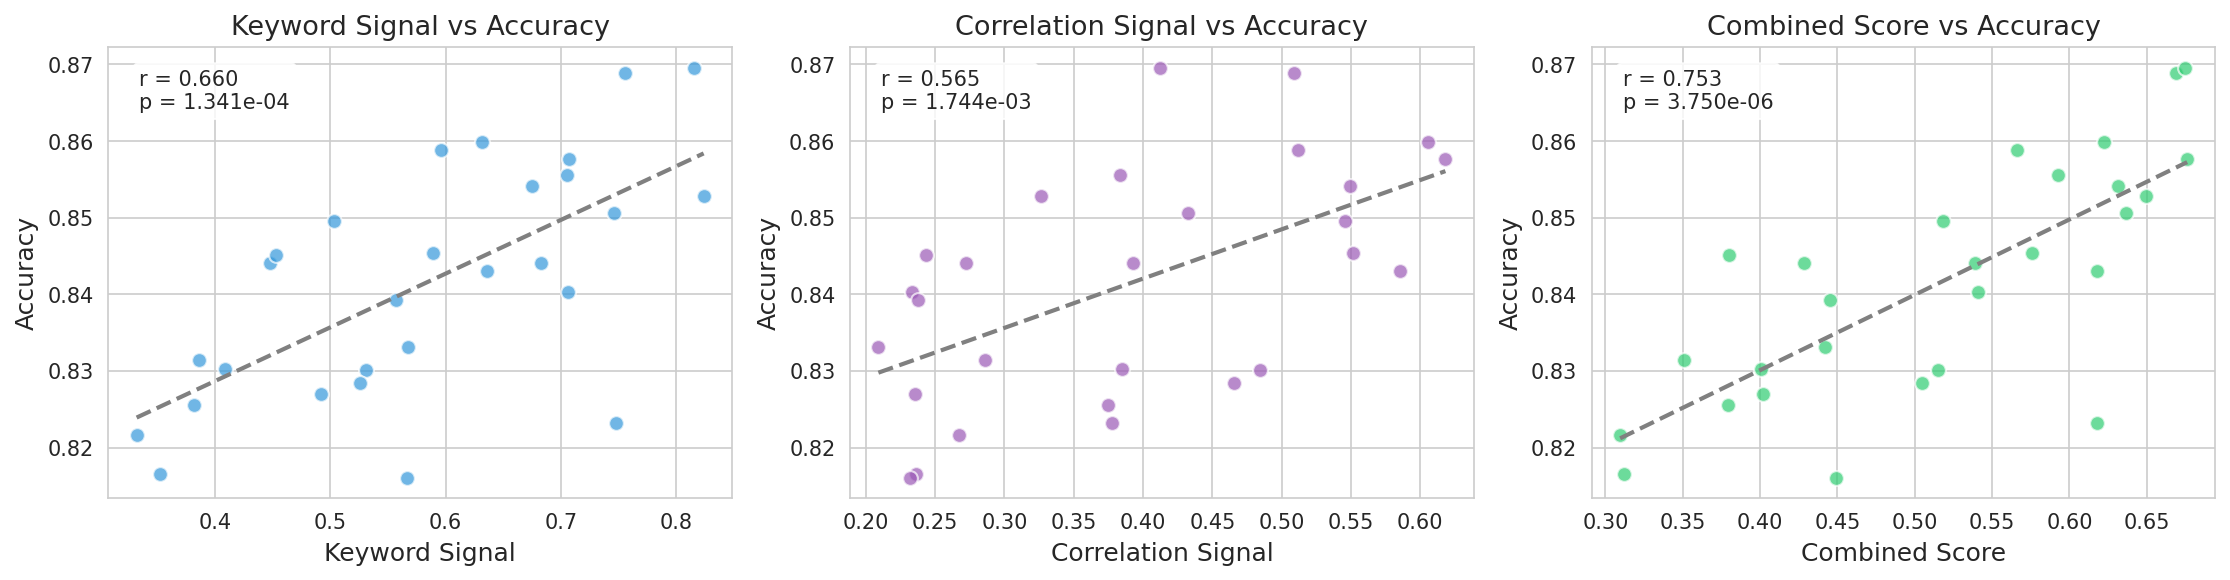

In [5]:
# 상관관계 시각화

if 'signal_df' in dir() and 'acc' in signal_df.columns:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    signals = [
        ("keyword_signal", "Keyword Signal", COLORS["keyword"]),
        ("corr_signal", "Correlation Signal", COLORS["corr"]),
        ("combined_score", "Combined Score", COLORS["combined"]),
    ]
    
    for idx, (col, title, color) in enumerate(signals):
        ax = axes[idx]
        if col in signal_df.columns:
            ax.scatter(signal_df[col], signal_df["acc"], 
                       alpha=0.7, c=color, s=50, edgecolors="white")
            
            # 회귀선
            z = np.polyfit(signal_df[col], signal_df["acc"], 1)
            p = np.poly1d(z)
            x_line = np.linspace(signal_df[col].min(), signal_df[col].max(), 100)
            ax.plot(x_line, p(x_line), "--", color="gray", linewidth=2)
            
            # 상관계수 표시
            r, pval = pearsonr(signal_df[col], signal_df["acc"])
            ax.text(0.05, 0.95, f"r = {r:.3f}\np = {pval:.3e}",
                    transform=ax.transAxes, fontsize=10,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            ax.set_xlabel(title)
            ax.set_ylabel("Accuracy")
            ax.set_title(f"{title} vs Accuracy")
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "q2_signal_correlation.pdf")
    plt.savefig(FIGURES_DIR / "q2_signal_correlation.png")
    plt.show()

## 3. PCL Score 시각화

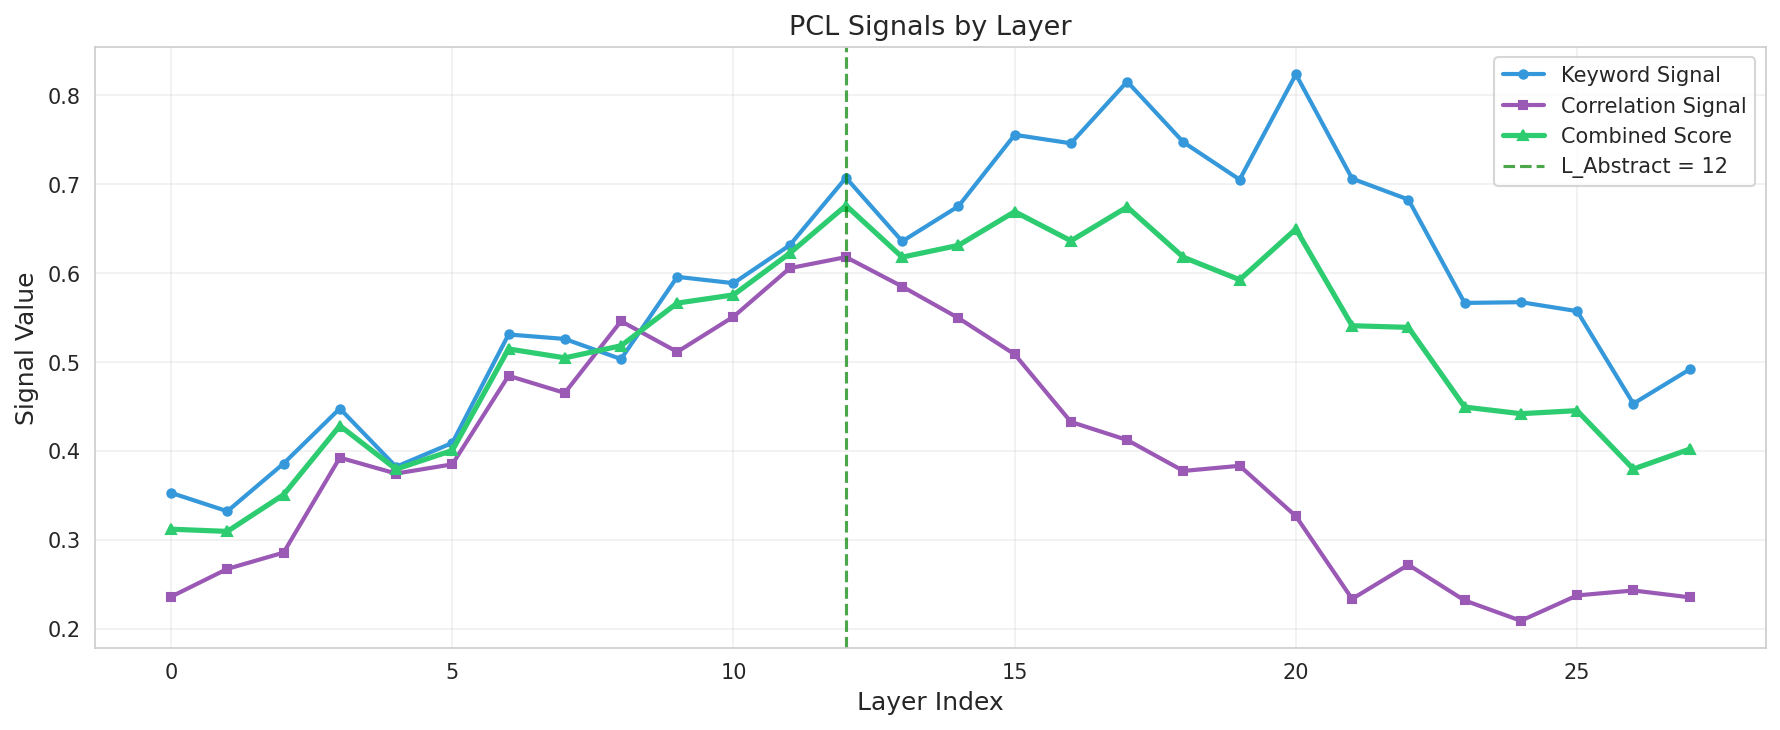

In [6]:
def plot_pcl_signals(signal_df: pd.DataFrame, meta: Dict = None, ax: plt.Axes = None):
    """
    PCL 신호 (keyword_signal, corr_signal, combined)를 레이어별로 시각화합니다.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    
    layers = signal_df["layer"].values
    
    # 신호 플롯
    if "keyword_signal" in signal_df.columns:
        ax.plot(layers, signal_df["keyword_signal"], 
                marker="o", markersize=4, label="Keyword Signal",
                color=COLORS["keyword"], linewidth=2)
    
    if "corr_signal" in signal_df.columns:
        ax.plot(layers, signal_df["corr_signal"], 
                marker="s", markersize=4, label="Correlation Signal",
                color=COLORS["corr"], linewidth=2)
    
    if "combined_score" in signal_df.columns:
        ax.plot(layers, signal_df["combined_score"], 
                marker="^", markersize=5, label="Combined Score",
                color=COLORS["combined"], linewidth=2.5)
    
    # 선택된 레이어 표시
    if meta and "L_Abstract" in meta:
        l_abs = meta["L_Abstract"]
        ax.axvline(x=l_abs, color="green", linestyle="--", alpha=0.7,
                   label=f"L_Abstract = {l_abs}")
    
    ax.set_xlabel("Layer Index")
    ax.set_ylabel("Signal Value")
    ax.set_title("PCL Signals by Layer")
    ax.legend(loc="best")
    ax.grid(True, alpha=0.3)
    
    return ax


# PCL 신호 시각화
if 'signal_df' in dir():
    fig, ax = plt.subplots(figsize=(12, 5))
    plot_pcl_signals(signal_df, signal_meta if 'signal_meta' in dir() else None, ax=ax)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "pcl_signals_by_layer.pdf")
    plt.savefig(FIGURES_DIR / "pcl_signals_by_layer.png")
    plt.show()

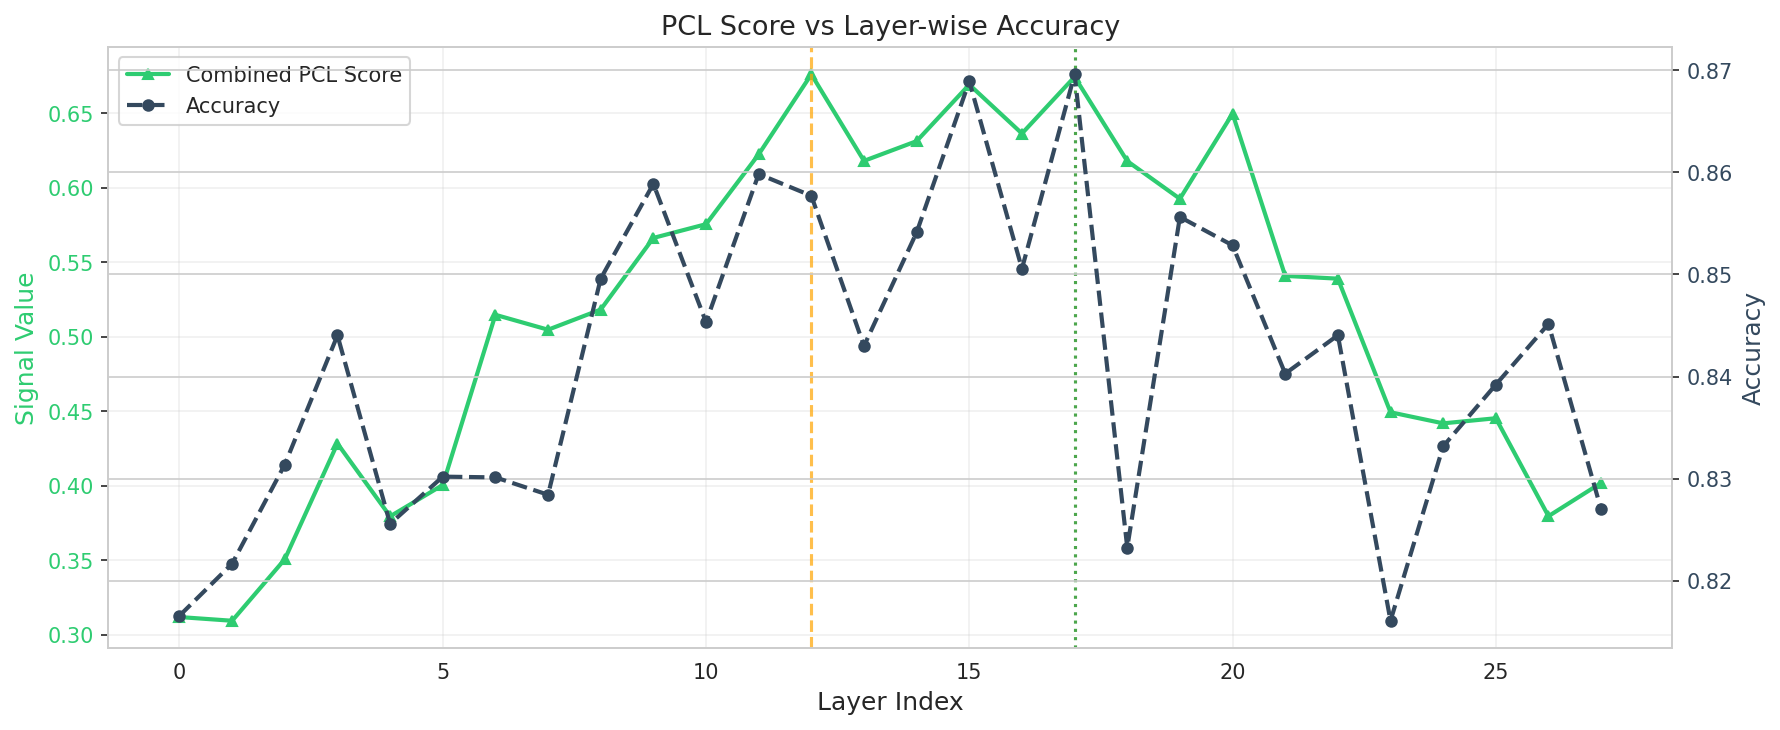

In [7]:
# PCL 신호와 Accuracy를 함께 표시 (dual axis)

if 'signal_df' in dir() and 'acc' in signal_df.columns:
    fig, ax1 = plt.subplots(figsize=(12, 5))
    
    layers = signal_df["layer"].values
    
    # 왼쪽 Y축: 신호
    ax1.set_xlabel("Layer Index")
    ax1.set_ylabel("Signal Value", color=COLORS["combined"])
    
    l1 = ax1.plot(layers, signal_df["combined_score"], 
                  marker="^", markersize=5, label="Combined PCL Score",
                  color=COLORS["combined"], linewidth=2)
    ax1.tick_params(axis='y', labelcolor=COLORS["combined"])
    
    # 오른쪽 Y축: Accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy", color=COLORS["acc"])
    
    l2 = ax2.plot(layers, signal_df["acc"], 
                  marker="o", markersize=5, label="Accuracy",
                  color=COLORS["acc"], linewidth=2, linestyle="--")
    ax2.tick_params(axis='y', labelcolor=COLORS["acc"])
    
    # 범례 합치기
    lines = l1 + l2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc="upper left")
    
    # Best/Selected 레이어 표시
    best_layer = signal_df.loc[signal_df["acc"].idxmax(), "layer"]
    ax1.axvline(x=best_layer, color="green", linestyle=":", alpha=0.7, label=f"Best = {best_layer}")
    
    if 'signal_meta' in dir() and "L_Abstract" in signal_meta:
        ax1.axvline(x=signal_meta["L_Abstract"], color="orange", linestyle="--", alpha=0.7)
    
    ax1.set_title("PCL Score vs Layer-wise Accuracy")
    ax1.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "pcl_vs_accuracy.pdf")
    plt.savefig(FIGURES_DIR / "pcl_vs_accuracy.png")
    plt.show()

## 4. ILM Head Effect 시각화

In [8]:
def create_synthetic_head_effects(n_layers: int = 28, n_heads: int = 16, seed: int = 42) -> np.ndarray:
    """
    시연용 합성 head effect 데이터를 생성합니다.
    """
    np.random.seed(seed)
    
    # 대부분의 head는 낮은 effect, 일부만 높은 effect
    effects = np.random.exponential(0.01, (n_layers, n_heads))
    
    # 특정 레이어에 높은 effect 추가
    high_effect_layers = [n_layers // 3, n_layers // 2, 2 * n_layers // 3]
    for layer in high_effect_layers:
        n_high = np.random.randint(2, 5)
        high_heads = np.random.choice(n_heads, n_high, replace=False)
        for head in high_heads:
            effects[layer, head] = np.random.uniform(0.1, 0.3)
    
    return effects


# ILM Head Effect 시각화
head_effects = create_synthetic_head_effects()
print(f"Head effects shape: {head_effects.shape}")

Head effects shape: (28, 16)


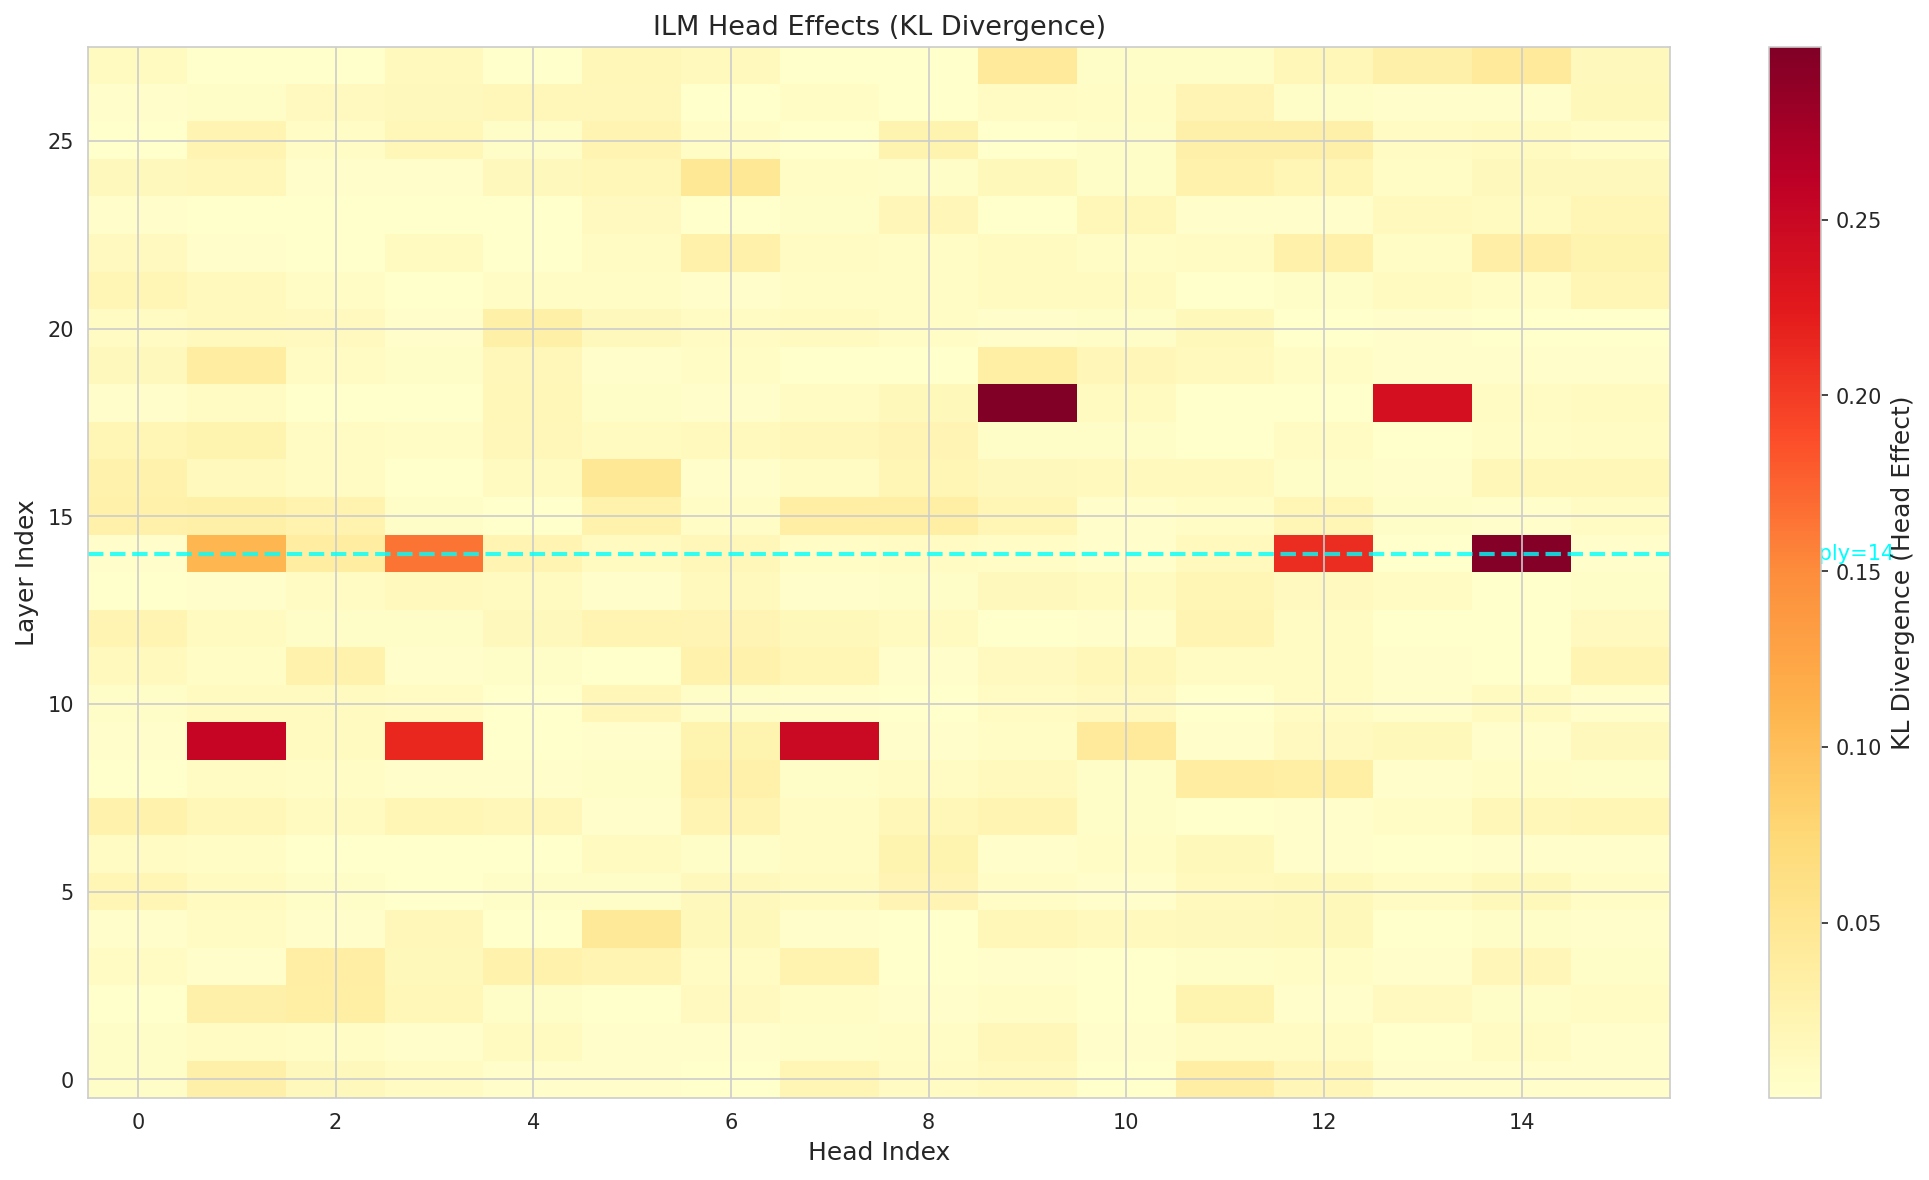

In [9]:
def plot_head_effects_heatmap(effects: np.ndarray, ax: plt.Axes = None, 
                              title: str = "ILM Head Effects") -> plt.Axes:
    """
    Head effect 히트맵을 그립니다.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 8))
    
    # 히트맵
    im = ax.imshow(effects, aspect="auto", cmap="YlOrRd", origin="lower")
    
    # 컬러바
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("KL Divergence (Head Effect)")
    
    ax.set_xlabel("Head Index")
    ax.set_ylabel("Layer Index")
    ax.set_title(title)
    
    # 레이어별 합계가 가장 높은 레이어 표시
    layer_sums = effects.sum(axis=1)
    best_layer = np.argmax(layer_sums)
    ax.axhline(y=best_layer, color="cyan", linestyle="--", linewidth=2, alpha=0.8)
    ax.text(effects.shape[1] + 0.5, best_layer, f"L_Apply={best_layer}", 
            va="center", fontsize=10, color="cyan")
    
    return ax


fig, ax = plt.subplots(figsize=(14, 8))
plot_head_effects_heatmap(head_effects, ax=ax, title="ILM Head Effects (KL Divergence)")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "ilm_head_effects_heatmap.pdf")
plt.savefig(FIGURES_DIR / "ilm_head_effects_heatmap.png")
plt.show()

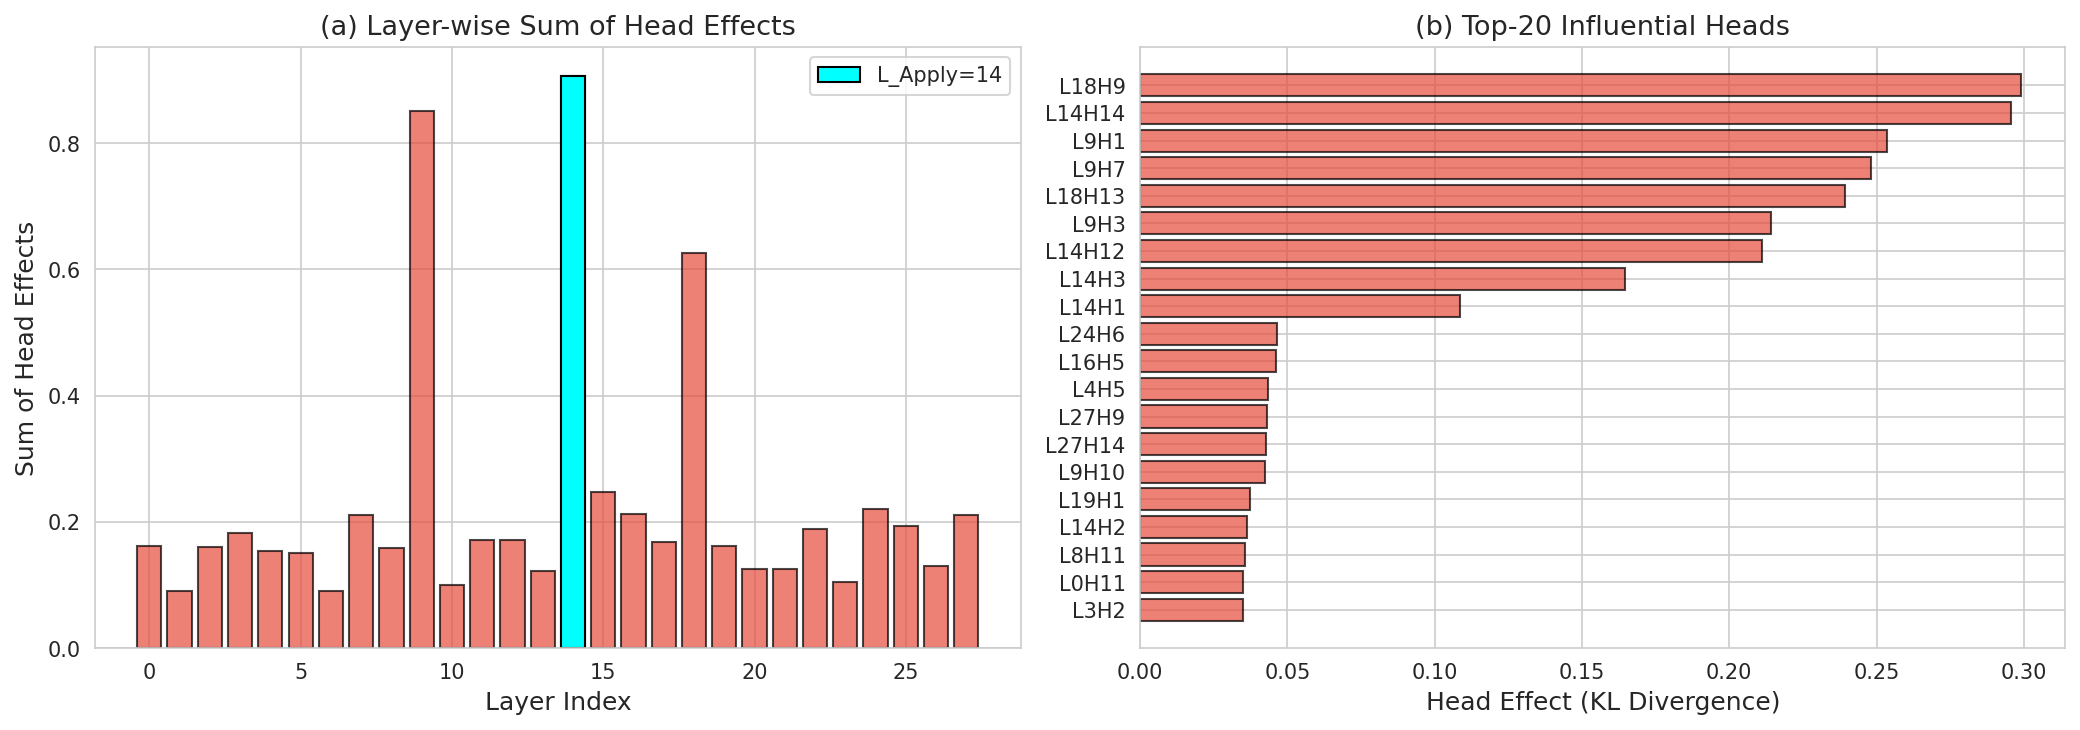

In [10]:
# 레이어별 Head Effect 합계

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (a) 레이어별 합계
ax1 = axes[0]
layer_sums = head_effects.sum(axis=1)
layers = np.arange(len(layer_sums))

ax1.bar(layers, layer_sums, color=COLORS["ilm"], alpha=0.7, edgecolor="black")
best_layer = np.argmax(layer_sums)
ax1.bar(best_layer, layer_sums[best_layer], color="cyan", edgecolor="black", label=f"L_Apply={best_layer}")

ax1.set_xlabel("Layer Index")
ax1.set_ylabel("Sum of Head Effects")
ax1.set_title("(a) Layer-wise Sum of Head Effects")
ax1.legend()

# (b) Top-K heads 분포
ax2 = axes[1]
flat_effects = head_effects.flatten()
top_k = 20
top_indices = np.argsort(flat_effects)[-top_k:][::-1]
top_values = flat_effects[top_indices]

# (layer, head) 좌표로 변환
top_coords = [(idx // head_effects.shape[1], idx % head_effects.shape[1]) for idx in top_indices]
labels = [f"L{l}H{h}" for l, h in top_coords]

ax2.barh(range(top_k), top_values, color=COLORS["ilm"], alpha=0.7, edgecolor="black")
ax2.set_yticks(range(top_k))
ax2.set_yticklabels(labels)
ax2.set_xlabel("Head Effect (KL Divergence)")
ax2.set_title(f"(b) Top-{top_k} Influential Heads")
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig(FIGURES_DIR / "ilm_layer_analysis.pdf")
plt.savefig(FIGURES_DIR / "ilm_layer_analysis.png")
plt.show()

## 5. Probe Accuracy 분석

In [11]:
def create_synthetic_probe_data(n_layers: int = 28, seed: int = 42) -> pd.DataFrame:
    """
    시연용 합성 probe accuracy 데이터를 생성합니다.
    """
    np.random.seed(seed)
    
    layers = np.arange(n_layers)
    
    # Probe accuracy: 후반 레이어로 갈수록 증가하는 경향 + 약간의 노이즈
    base_acc = 0.5 + 0.35 * (layers / n_layers)
    probe_acc = base_acc + np.random.normal(0, 0.02, n_layers)
    probe_acc = np.clip(probe_acc, 0.4, 0.95)
    
    # 최종 test accuracy (probe와 어느 정도 상관)
    test_acc = 0.7 + 0.2 * (probe_acc - 0.5) + np.random.normal(0, 0.015, n_layers)
    test_acc = np.clip(test_acc, 0.75, 0.92)
    
    return pd.DataFrame({
        "layer": layers,
        "probe_acc": probe_acc,
        "test_acc": test_acc,
    })


probe_df = create_synthetic_probe_data()
probe_df.head()

,layer,probe_acc,test_acc
0,0,0.509934,0.75
1,1,0.509735,0.75
2,2,0.537954,0.75
3,3,0.567961,0.75
4,4,0.545317,0.75


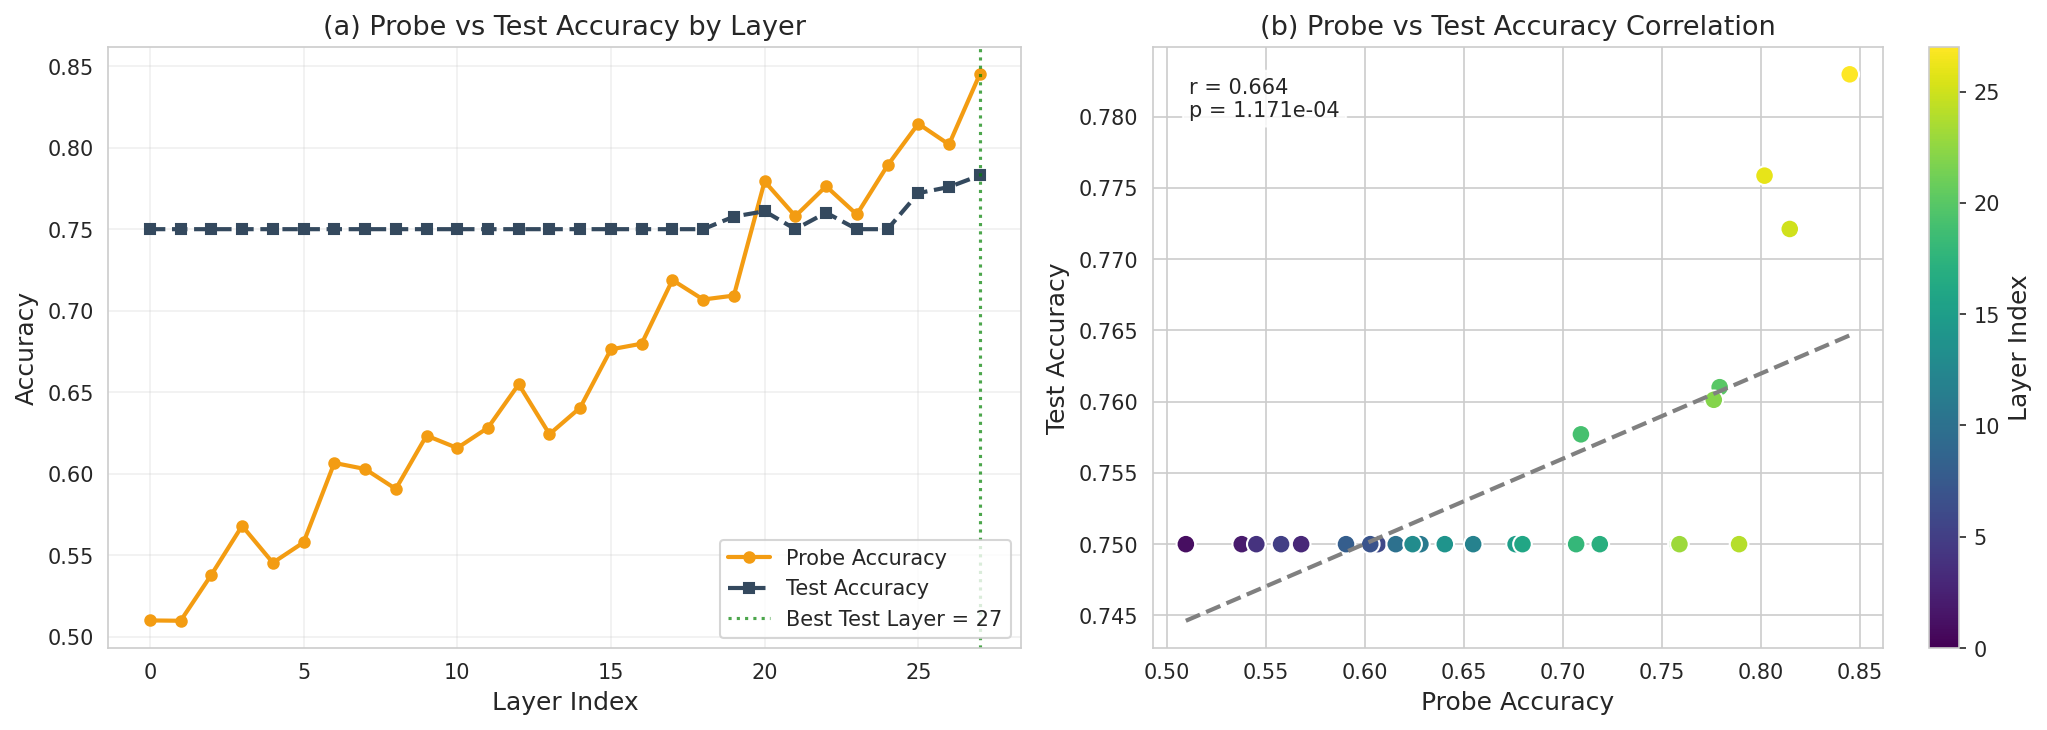

In [12]:
# Probe Accuracy 분석

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (a) 레이어별 Probe Accuracy vs Test Accuracy
ax1 = axes[0]
ax1.plot(probe_df["layer"], probe_df["probe_acc"], 
         marker="o", markersize=5, label="Probe Accuracy",
         color=COLORS["probe"], linewidth=2)
ax1.plot(probe_df["layer"], probe_df["test_acc"], 
         marker="s", markersize=5, label="Test Accuracy",
         color=COLORS["acc"], linewidth=2, linestyle="--")

# Best 레이어 표시
best_test = probe_df.loc[probe_df["test_acc"].idxmax(), "layer"]
ax1.axvline(x=best_test, color="green", linestyle=":", alpha=0.7, 
            label=f"Best Test Layer = {best_test}")

ax1.set_xlabel("Layer Index")
ax1.set_ylabel("Accuracy")
ax1.set_title("(a) Probe vs Test Accuracy by Layer")
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# (b) Probe Accuracy vs Test Accuracy 산점도
ax2 = axes[1]
ax2.scatter(probe_df["probe_acc"], probe_df["test_acc"], 
            c=probe_df["layer"], cmap="viridis", s=80, edgecolors="white")

# 회귀선
z = np.polyfit(probe_df["probe_acc"], probe_df["test_acc"], 1)
p = np.poly1d(z)
x_line = np.linspace(probe_df["probe_acc"].min(), probe_df["probe_acc"].max(), 100)
ax2.plot(x_line, p(x_line), "--", color="gray", linewidth=2)

# 상관계수
r, pval = pearsonr(probe_df["probe_acc"], probe_df["test_acc"])
ax2.text(0.05, 0.95, f"r = {r:.3f}\np = {pval:.3e}",
         transform=ax2.transAxes, fontsize=10,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

cbar = plt.colorbar(ax2.collections[0], ax=ax2)
cbar.set_label("Layer Index")

ax2.set_xlabel("Probe Accuracy")
ax2.set_ylabel("Test Accuracy")
ax2.set_title("(b) Probe vs Test Accuracy Correlation")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "probe_accuracy_analysis.pdf")
plt.savefig(FIGURES_DIR / "probe_accuracy_analysis.png")
plt.show()

## 6. 신호 조합 효과

In [13]:
# 모든 신호를 합쳐서 분석

if 'signal_df' in dir() and 'probe_df' in dir():
    # 데이터 병합
    combined_df = signal_df.merge(probe_df[["layer", "probe_acc"]], on="layer", how="left")
    
    # ILM layer sum 추가
    if 'head_effects' in dir():
        ilm_sums = head_effects.sum(axis=1)
        combined_df["ilm_sum"] = ilm_sums[:len(combined_df)]
    
    print("Combined Signal DataFrame:")
    display(combined_df.head())

Combined Signal DataFrame:


,layer,keyword_signal,corr_signal,combined_score,acc,probe_acc,ilm_sum
0,0,0.352903,0.236115,0.312027,0.816570,0.509934,0.162225
1,1,0.332231,0.267396,0.309539,0.821671,0.509735,0.090738
2,2,0.385875,0.285698,0.350813,0.831378,0.537954,0.160053
3,3,0.447769,0.392489,0.428421,0.844029,0.567961,0.182635
4,4,0.382243,0.374621,0.379575,0.825574,0.545317,0.153446


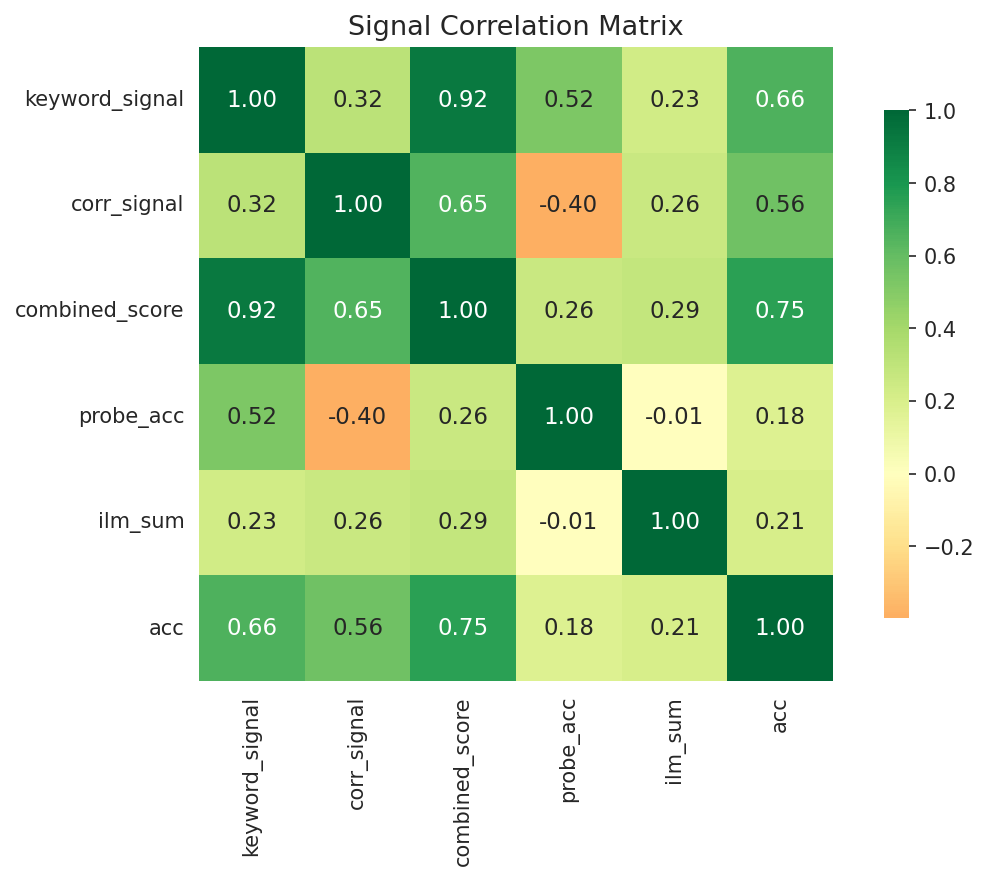

In [14]:
# 상관 행렬 시각화

if 'combined_df' in dir():
    # 분석할 열 선택
    cols = [c for c in ["keyword_signal", "corr_signal", "combined_score", 
                        "probe_acc", "ilm_sum", "acc"] if c in combined_df.columns]
    
    if len(cols) >= 2:
        corr_matrix = combined_df[cols].corr()
        
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap="RdYlGn", center=0,
                    fmt=".2f", ax=ax, square=True,
                    cbar_kws={"shrink": 0.8})
        ax.set_title("Signal Correlation Matrix")
        
        plt.tight_layout()
        plt.savefig(FIGURES_DIR / "signal_correlation_matrix.pdf")
        plt.savefig(FIGURES_DIR / "signal_correlation_matrix.png")
        plt.show()

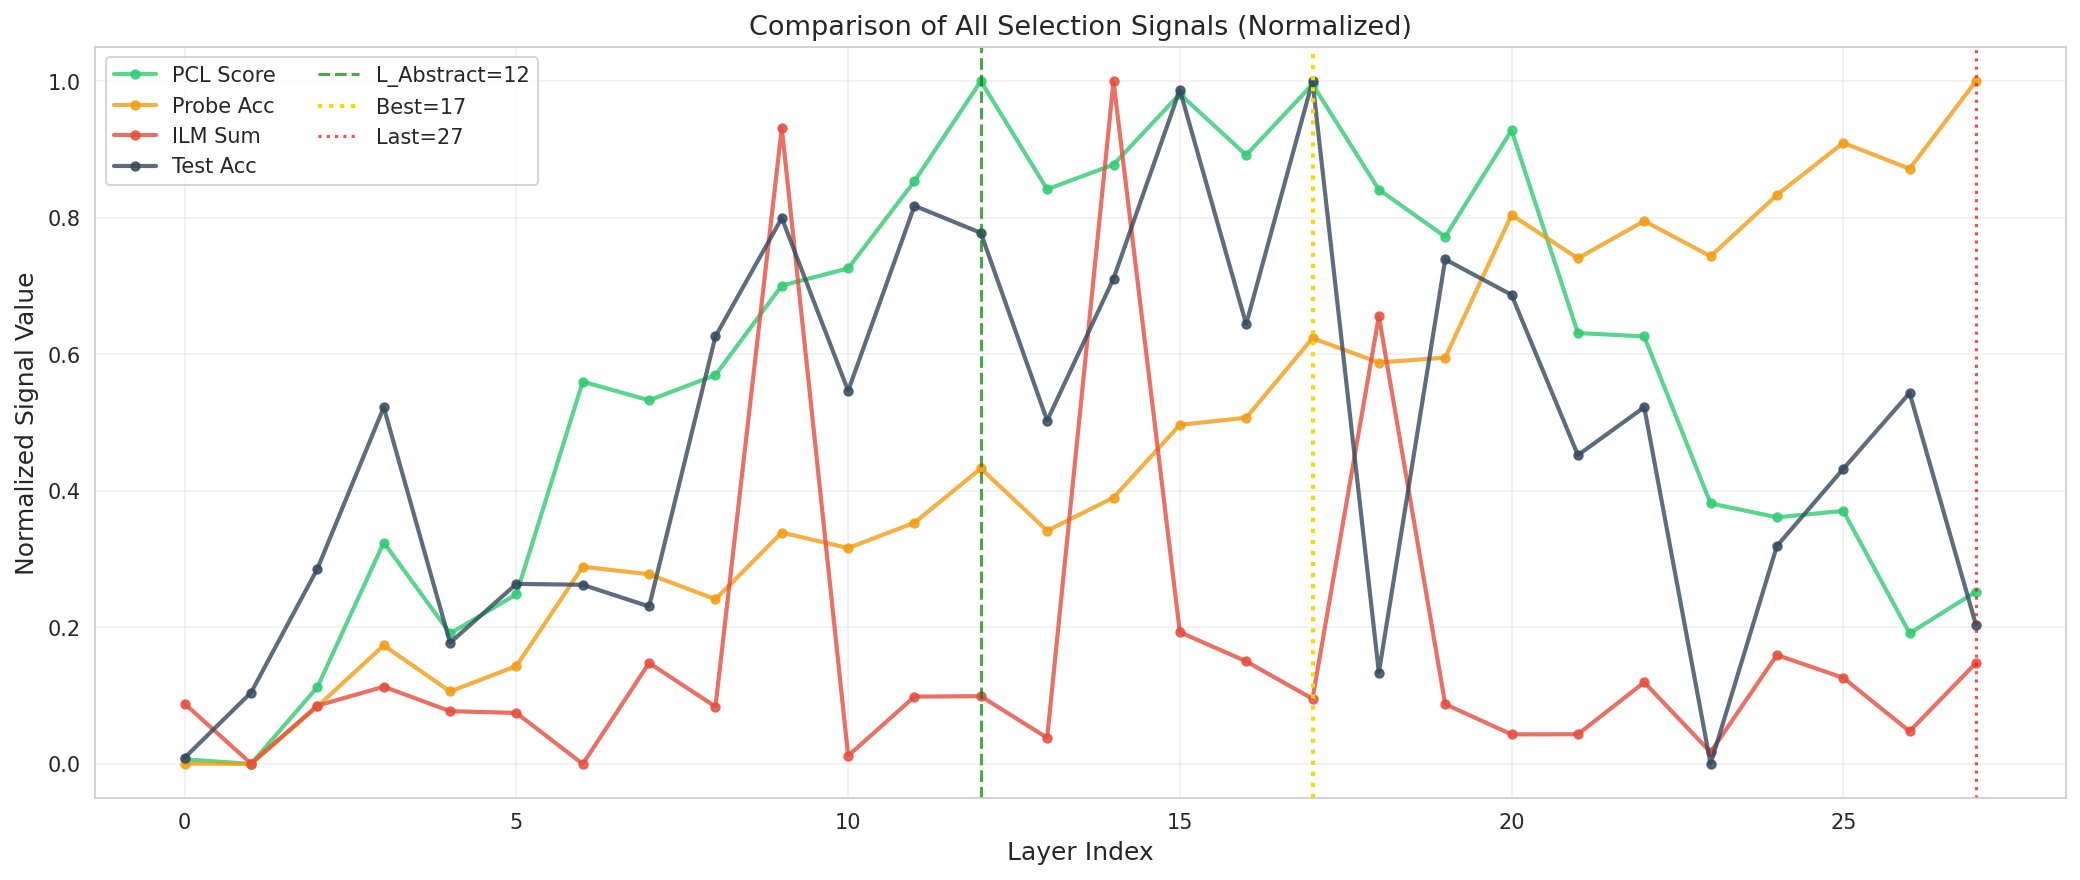

In [15]:
# 레이어별 신호 종합 비교 (선택된 레이어 중심)

if 'combined_df' in dir() and 'signal_meta' in dir():
    fig, ax = plt.subplots(figsize=(14, 6))
    
    layers = combined_df["layer"].values
    
    # 각 신호를 정규화하여 같은 스케일로
    def normalize(x):
        return (x - x.min()) / (x.max() - x.min() + 1e-8)
    
    signals_to_plot = []
    if "combined_score" in combined_df.columns:
        signals_to_plot.append(("PCL Score", normalize(combined_df["combined_score"]), COLORS["combined"]))
    if "probe_acc" in combined_df.columns:
        signals_to_plot.append(("Probe Acc", normalize(combined_df["probe_acc"]), COLORS["probe"]))
    if "ilm_sum" in combined_df.columns:
        signals_to_plot.append(("ILM Sum", normalize(combined_df["ilm_sum"]), COLORS["ilm"]))
    if "acc" in combined_df.columns:
        signals_to_plot.append(("Test Acc", normalize(combined_df["acc"]), COLORS["acc"]))
    
    for name, values, color in signals_to_plot:
        ax.plot(layers, values, marker="o", markersize=4, 
                label=name, color=color, linewidth=2, alpha=0.8)
    
    # 선택된 레이어들 표시
    l_abstract = signal_meta.get("L_Abstract", -1)
    if l_abstract >= 0:
        ax.axvline(x=l_abstract, color="green", linestyle="--", alpha=0.7, 
                   label=f"L_Abstract={l_abstract}")
    
    if "acc" in combined_df.columns:
        best_layer = int(combined_df.loc[combined_df["acc"].idxmax(), "layer"])
        ax.axvline(x=best_layer, color="gold", linestyle=":", linewidth=2,
                   label=f"Best={best_layer}")
    
    ax.axvline(x=len(layers)-1, color="red", linestyle=":", alpha=0.7,
               label=f"Last={len(layers)-1}")
    
    ax.set_xlabel("Layer Index")
    ax.set_ylabel("Normalized Signal Value")
    ax.set_title("Comparison of All Selection Signals (Normalized)")
    ax.legend(loc="upper left", ncol=2)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "all_signals_comparison.pdf")
    plt.savefig(FIGURES_DIR / "all_signals_comparison.png")
    plt.show()

## Summary

### Q2 분석 결과 요약

**Signal-Performance Correlations:**
- PCL Combined Score: 최종 accuracy와의 상관계수
- Probe Accuracy: 레이어별 probe와 test accuracy 간 관계
- ILM Head Effects: 인과적 영향력과 성능 간 관계

### 생성된 Figure 목록:
1. `q2_signal_correlation.pdf/png` - 신호-성능 산점도
2. `pcl_signals_by_layer.pdf/png` - PCL 신호 레이어별 분포
3. `pcl_vs_accuracy.pdf/png` - PCL과 accuracy 비교
4. `ilm_head_effects_heatmap.pdf/png` - ILM head effect 히트맵
5. `ilm_layer_analysis.pdf/png` - ILM 레이어별 분석
6. `probe_accuracy_analysis.pdf/png` - Probe accuracy 분석
7. `signal_correlation_matrix.pdf/png` - 신호 상관 행렬
8. `all_signals_comparison.pdf/png` - 모든 신호 종합 비교

In [16]:
# 생성된 figure 파일 목록
print("Generated figures:")
for f in sorted(FIGURES_DIR.glob("*")):
    print(f"  - {f.name}")

Generated figures:
  - all_signals_comparison.pdf
  - all_signals_comparison.png
  - ilm_head_effects_heatmap.pdf
  - ilm_head_effects_heatmap.png
  - ilm_layer_analysis.pdf
  - ilm_layer_analysis.png
  - pcl_signals_by_layer.pdf
  - pcl_signals_by_layer.png
  - pcl_vs_accuracy.pdf
  - pcl_vs_accuracy.png
  - probe_accuracy_analysis.pdf
  - probe_accuracy_analysis.png
  - q2_signal_correlation.pdf
  - q2_signal_correlation.png
  - signal_correlation_matrix.pdf
  - signal_correlation_matrix.png
